In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
data = pd.read_csv('monthly_milk_production.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
production = data['Production'].astype(float).values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(production)

In [4]:
window_size = 12
X = []
y = []
target_dates = data.index[window_size:]

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, target_dates, test_size=0.2, shuffle=False
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [5]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

rmse = np.sqrt(np.mean((y_test - predictions)**2))
print(f'RMSE: {rmse:.2f}')

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - loss: 0.1659 - val_loss: 0.0273
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0349 - val_loss: 0.0389
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0294 - val_loss: 0.0536
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0363 - val_loss: 0.0477
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0244 - val_loss: 0.0269
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0261 - val_loss: 0.0293
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0302 - val_loss: 0.0300
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0250 - val_loss: 0.0346
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0265 - val_loss: 0.0268
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0236 - val_loss: 0.0263
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0245 - val_loss: 0.0275
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0249 - val_

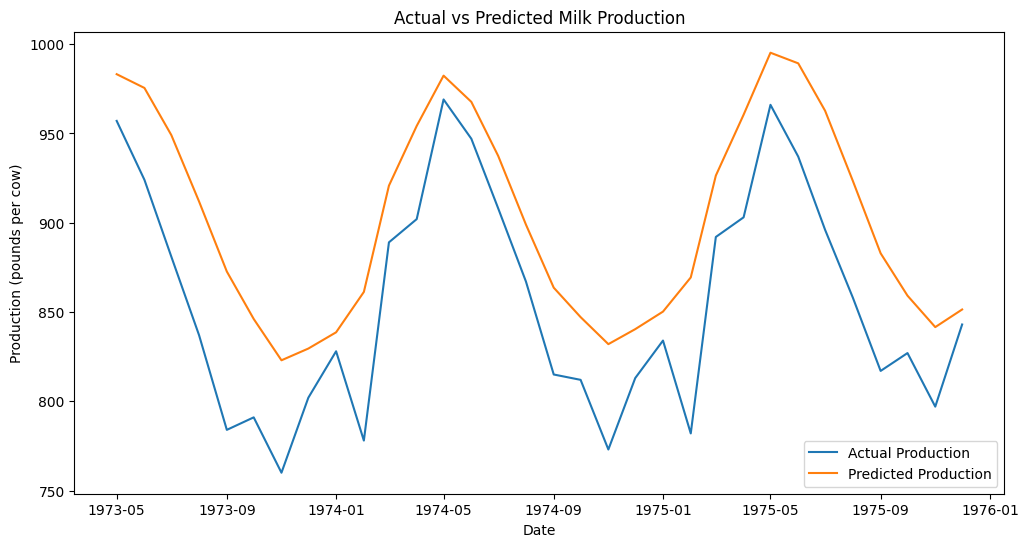

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual Production')
plt.plot(dates_test, predictions, label='Predicted Production')
plt.title('Actual vs Predicted Milk Production')
plt.xlabel('Date')
plt.ylabel('Production (pounds per cow)')
plt.legend()
plt.show()